In [49]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow_probability as tfp
from scipy.interpolate import RectBivariateSpline
import numpy as np
import matplotlib.pyplot as plt
import corner
import importlib
import logging
from tensorflow import keras
import os

import torch
from torch import nn
from torch import optim
from tqdm import tqdm

from nflows.flows.base import Flow
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.distributions.normal import ConditionalDiagonalNormal
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

importlib.reload(logging)

# limit GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(gpus[1],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


In [50]:
data = np.load('../../Data/sample_NuFit0911.npz')
data_all = np.column_stack([data['ve_dune'][:,:36], data['vu_dune'][:,:36], data['vebar_dune'][:,:36], data['vubar_dune'][:,:36]])

In [ ]:
flow = torch.load('./nf/test.pt')

In [ ]:
n_sample = 10000
samples = flow.sample(num_samples=n_sample,
            context=torch.tensor(np.array([x_val[0]/1000]), dtype=torch.float32)).cpu().detach().numpy()

In [ ]:
plt.plot(samples[:, 1], samples[:, 2])
plt.xlabel('theta23')
plt.ylabel('deltacp')

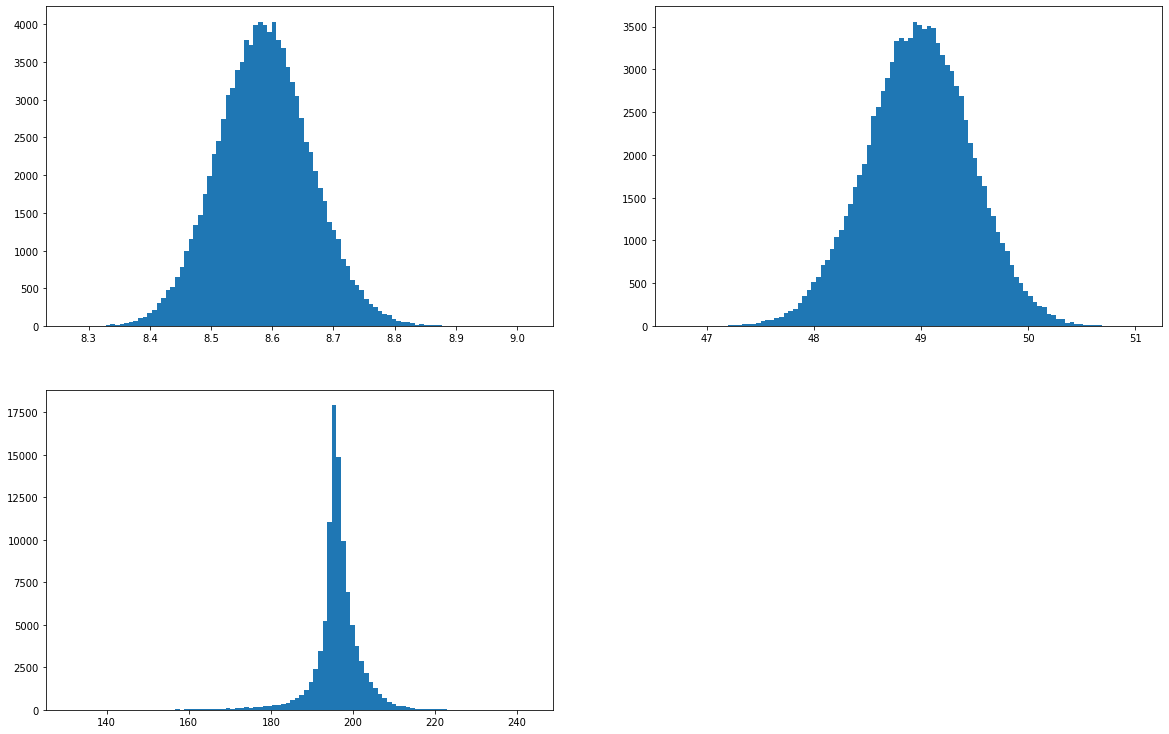

In [68]:
plt.figure(figsize=(20, 20))
for i in range(3):
    plt.subplot(3, 2, i+1)
    plt.hist(reconstruction_mean[:, i]*180/np.pi, bins=100)
plt.show()

In [69]:
N_DUNE, N_T2HK, N_DUT2 = 92, 36, 96
theta23_DUNE, delta_cp_DUNE, chi_DUNE = [], [], []
theta23_T2HK, delta_cp_T2HK, chi_T2HK = [], [], []
theta23_DUT2, delta_cp_DUT2, chi_DUT2 = [], [], []

In [70]:
f_DUNE = open("../../Data/chi_square-4-2_figB_DUNE.txt")
for i in range(N_DUNE):
    s = f_DUNE.readline().split()
    array = []
    for j in range(len(s)) :
        array.append(float(s[j])) 
    theta23_DUNE.append(array[0])
    delta_cp_DUNE.append(array[1]) 
    chi_DUNE.append(array[2])
f_DUNE.close()
f_T2HK = open("../../Data/chi_square-4-2_figB_T2HK.txt")
for i in range(N_T2HK):
    s = f_T2HK.readline().split()
    array = []
    for j in range(len(s)) :
        array.append(float(s[j])) 
    theta23_T2HK.append(array[0])
    delta_cp_T2HK.append(array[1]) 
    chi_T2HK.append(array[2])
f_T2HK.close()
f_DUT2 = open("../../Data/chi_square-4-2_figB_DUT2.txt")
for i in range(N_DUT2):
    s = f_DUT2.readline().split()
    array = []
    for j in range(len(s)) :
        array.append(float(s[j])) 
    theta23_DUT2.append(array[0])
    delta_cp_DUT2.append(array[1]) 
    chi_DUT2.append(array[2])
f_DUT2.close()

In [71]:
theta23_DUNE = np.array(theta23_DUNE)
delta_cp_DUNE = np.array(delta_cp_DUNE)
chi_DUNE = np.array(chi_DUNE)
theta23_T2HK = np.array(theta23_T2HK)
delta_cp_T2HK = np.array(delta_cp_T2HK)
chi_T2HK = np.array(chi_T2HK)
theta23_DUT2 = np.array(theta23_DUT2)
delta_cp_DUT2 = np.array(delta_cp_DUT2)
chi_DUT2 = np.array(chi_DUT2)

In [72]:
x0 = np.linspace(min(theta23_DUNE)-3, max(theta23_DUNE)+3, 68)
y0 = np.linspace(min(delta_cp_DUNE)-6, max(delta_cp_DUNE)+6, 20)
X0, Y0 = np.meshgrid(x0, y0)
Z0 = np.zeros((len(X0),len(X0[0])))

for i in range(len(theta23_DUNE)):
    a = np.where(X0 == theta23_DUNE[i])[1][0]
    b = np.where(Y0 == delta_cp_DUNE[i])[0][0]
    Z0[b][a] = 1

x1 = np.linspace(min(theta23_T2HK)-3, max(theta23_T2HK)+3, 65)
y1 = np.linspace(min(delta_cp_T2HK)-6, max(delta_cp_T2HK)+6, 14)
X1, Y1 = np.meshgrid(x1, y1)
Z1 = np.zeros((len(X1),len(X1[0])))

for i in range(len(theta23_T2HK)):
    a = np.where(X1 == theta23_T2HK[i])[1][0]
    b = np.where(Y1 == delta_cp_T2HK[i])[0][0]
    Z1[b][a] = 1

x2 = np.linspace(min(theta23_DUT2)-3, max(theta23_DUT2)+3, 129)
y2 = np.linspace(min(delta_cp_DUT2)-6, max(delta_cp_DUT2)+6, 25)
X2, Y2 = np.meshgrid(x2, y2)
Z2 = np.zeros((len(X2),len(X2[0])))

for i in range(len(theta23_DUT2)):
    a = np.where(X2 == theta23_DUT2[i])[1][0]
    b = np.where(Y2 == delta_cp_DUT2[i])[0][0]
    Z2[b][a] = 1

/tmp/ipykernel_2360193/8899176.py:11: UserWarning: No contour levels were found within the data range.
  DUT2 = plot_axis.contour(X0, Y0, Z0, 0, colors='blue', linestyles="-", linewidths=1)


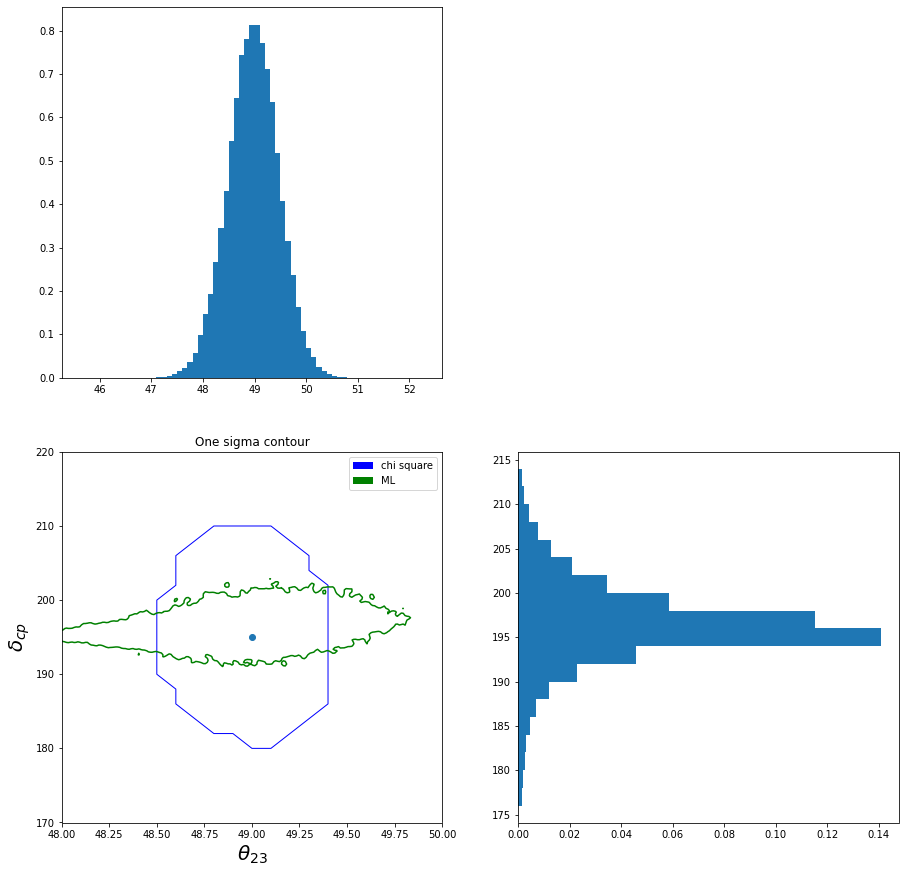

In [75]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
plot_axis = plt.subplot(2,2,1)
plot_axis.hist(reconstruction_mean[:, 1]*180/np.pi,density=1,bins=x0)

plot_axis = plt.subplot(2,2,4)

plot_axis.hist(reconstruction_mean[:, 2]*180/np.pi,orientation="horizontal",density=1, bins=y0)

plot_axis = plt.subplot(2,2,3)
plot_axis.set_title('One sigma contour')
DUT2 = plot_axis.contour(X0, Y0, Z0, 0, colors='blue', linestyles="-", linewidths=1)
corner.hist2d(reconstruction_mean[:, 1]*180/np.pi, reconstruction_mean[:, 2]*180/np.pi,
                    levels=(0.68,),
                    scale_hist=True,
                    plot_datapoints=False,
                    color='green',
                    labels= ["$\\theta_{23} $($^\circ$)", "$\delta_{cp} $($^\circ$)"],
                    range=[[48,50], [170, 220]],
                    plot_contours = True,
                    plot_density = False,
                    fontsize=30,
                    bins = [200, 200],
                    label_kwargs={"fontsize": 30},
                    smooth=True
                   )
plt.scatter(data['theta23'][0], data['delta'][0])
plot_axis.set_xlabel(r'$\theta_{23} $', fontsize=20)
plot_axis.set_ylabel(r'$\delta_{cp} $', fontsize=20)
proxy = [plt.Rectangle((2, 2), 0.0, 3, 90, fc=c) for c in ['blue', 'green']]
plt.legend(proxy, ["chi square", "ML"])
plt.show()